In [320]:
! pip install kaggle fastai dtreeviz scipy

import kaggle
import shutil
from pathlib import Path
import pandas as pd
import numpy as np
from fastai.tabular.all import TabularPandas, Categorify, FillMissing, cont_cat_split, RandomSplitter, range_of
from dtreeviz.trees import ShadowDecTree, DTreeVizAPI
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import math
import matplotlib.pyplot as plt
import scipy
from scipy.cluster import hierarchy as hc
import re

In [321]:
path = Path('.')/'data'
kaggle.api.competition_download_cli('titanic', path=path)
shutil.unpack_archive(str(path/'titanic.zip'), str(path))

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [322]:
df_raw = pd.read_csv(path/'train.csv', low_memory=False)

In [342]:
# df['PassengerId'] = df['PassengerId'].astype('category')

ticket_re = re.compile('((?P<class>[\w\/\.]+)\s)?(?P<ticket_number>\d+)')
def get_ticket_class(ticket):
    match = ticket_re.match(ticket)
    if not match: return
    return match.groupdict().get('class')


df_raw['Pclass'] = df_raw['Pclass'].astype('category')
df_raw['Pclass'].cat.set_categories([3, 2, 1], ordered=True)
df_raw['Survived'] = df_raw['Survived'].astype('category')
df_raw['FamilyName'] = df_raw['Name'].str.split(',', expand=True)[0]
df_raw['FamilySize'] = df_raw['FamilyName'].map(lambda s: df_raw.query('FamilyName == @s').shape[0])
df_raw['IsChild'] = df_raw['Age'] < 18
df_raw['Deck'] = df_raw['Cabin'].str[0].astype('category')
df_raw['CabinNumber'] = df_raw['Cabin'].str[1:]
df_raw['CabinOccupants'] = df_raw['Cabin'].map(lambda s: df_raw.query('Cabin == @s').shape[0])
df_raw['TicketClass'] = df_raw['Ticket'].map(get_ticket_class)

df = df_raw[['Survived', 'Pclass', 'Name', 'FamilyName', 'FamilySize', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'IsChild', 'Deck', 'CabinNumber', 'CabinOccupants', 'TicketClass']]

continuous_cols, categorical_cols = cont_cat_split(df, max_card=1, dep_var='Survived')
df.query("Age.isnull()")


,Survived,Pclass,Name,FamilyName,FamilySize,Sex,Age,SibSp,Parch,Fare,Embarked,IsChild,Deck,CabinNumber,CabinOccupants,TicketClass
5,0,3,"Moran, Mr. James",Moran,3,male,NaN,0,0,8.4583,Q,False,NaN,NaN,0,None
17,1,2,"Williams, Mr. Charles Eugene",Williams,4,male,NaN,0,0,13.0000,S,False,NaN,NaN,0,None
19,1,3,"Masselmani, Mrs. Fatima",Masselmani,1,female,NaN,0,0,7.2250,C,False,NaN,NaN,0,None
26,0,3,"Emir, Mr. Farred Chehab",Emir,1,male,NaN,0,0,7.2250,C,False,NaN,NaN,0,None
28,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",O'Dwyer,1,female,NaN,0,0,7.8792,Q,False,NaN,NaN,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,0,3,"Razi, Mr. Raihed",Razi,1,male,NaN,0,0,7.2292,C,False,NaN,NaN,0,None
863,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",Sage,7,female,NaN,8,2,69.5500,S,False,NaN,NaN,0,CA.
868,0,3,"van Melkebeke, Mr. Philemon",van Melkebeke,1,male,NaN,0,0,9.5000,S,False,NaN,NaN,0,None
878,0,3,"Laleff, Mr. Kristo",Laleff,1,male,NaN,0,0,7.8958,S,False,NaN,NaN,0,None


In [324]:

to = TabularPandas(df=df,
                   procs=[Categorify, FillMissing],
                   cont_names=continuous_cols,
                   cat_names=categorical_cols,
                   y_names='Survived',
                   splits=RandomSplitter(valid_pct=0.2)(range_of(df)))
len(to.train), len(to.valid)

/Users/bryan/Documents/kaggle/.venv/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/bryan/Documents/kaggle/.venv/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/bryan/Documents/kaggle/.venv/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/bryan/Documents/kaggle/.venv/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/bryan/Documents/kaggle/.venv/lib/python3.11/site-packages/fast

(713, 178)

In [325]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y);

/Users/bryan/Documents/kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


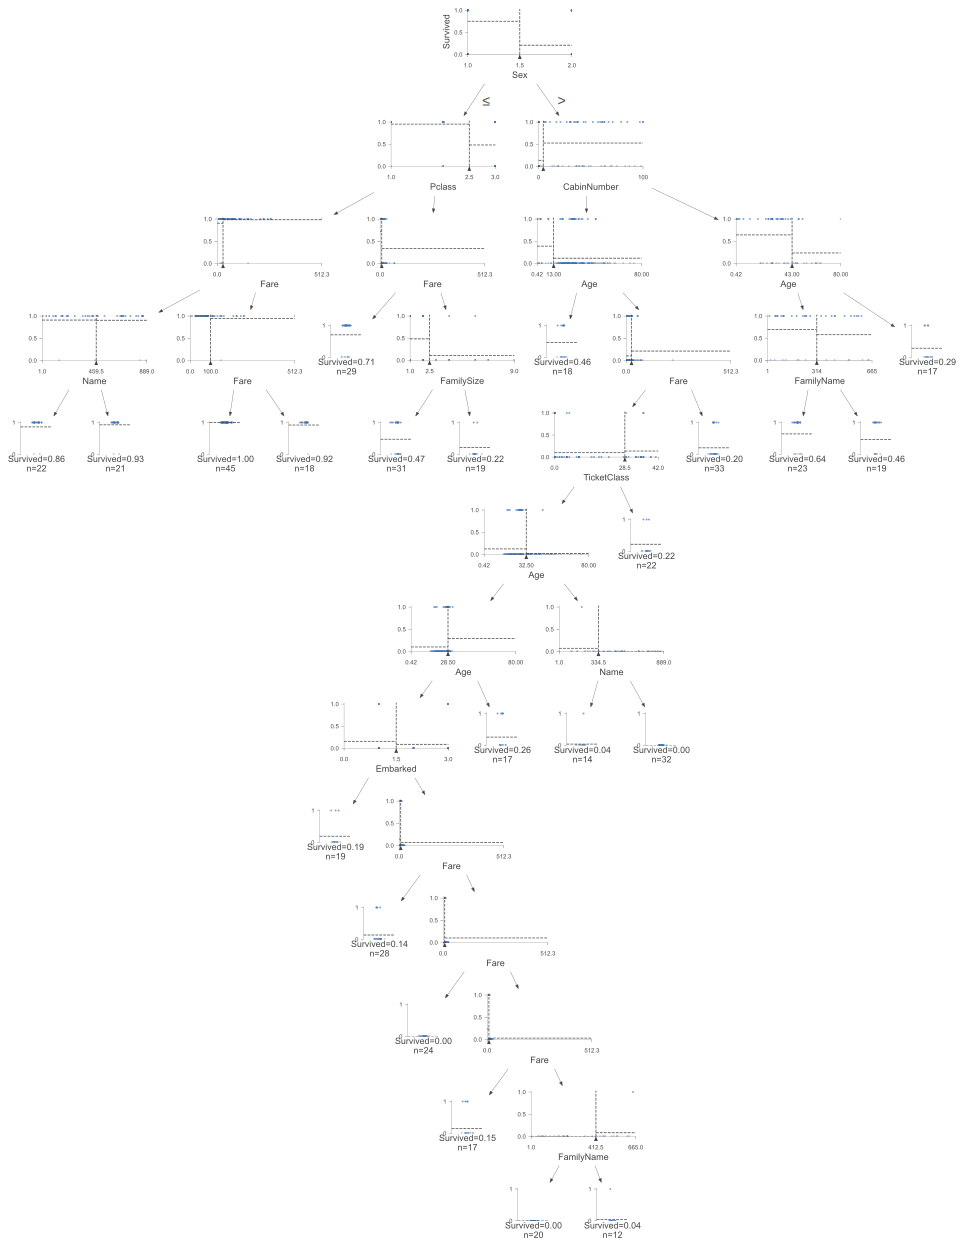

In [326]:
samp_idx = np.random.permutation(len(to.train.y))[:500]
shadow_tree = ShadowDecTree.get_shadow_tree(m,
                                            to.train.xs.iloc[samp_idx],
                                            to.train.y.iloc[samp_idx],
                                            to.train.xs.columns,
                                            'Survived')
model = DTreeVizAPI(shadow_tree)
model.view()

In [327]:
m.get_n_leaves(), len(to.train.xs)

(22, 713)

In [328]:
preds = np.rint(m.predict(to.valid.xs))

In [329]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [330]:
(preds==to.valid.y).sum() / len(preds)


0.797752808988764

In [331]:
m_rmse(m, to.train.xs, to.train.y), m_rmse(m, to.valid.xs, to.valid.y)

(0.350708, 0.367663)

In [332]:
rfm = RandomForestRegressor(n_jobs=-1, n_estimators=40, max_features=0.5,
        min_samples_leaf=5, oob_score=True).fit(to.train.xs, to.train.y)

In [333]:
m_rmse(rfm, to.train.xs, to.train.y), m_rmse(rfm, to.valid.xs, to.valid.y)

(0.282284, 0.345041)

/Users/bryan/Documents/kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/bryan/Documents/kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/bryan/Documents/kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/bryan/Documents/kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/bryan/Documents/kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/bryan/Documents/kaggle/.venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has 

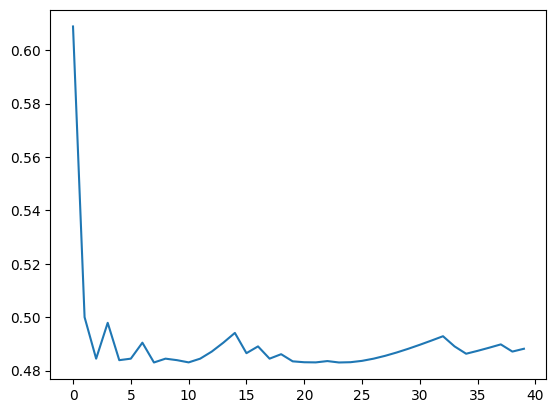

In [334]:
preds2 = np.stack([t.predict(to.valid.xs) for t in rfm.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), to.valid.y) for i in range(40)]);

In [335]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [336]:
fi = rf_feat_importance(rfm, to.train.xs)
fi[:10]

,cols,imp
3,Sex,0.383942
14,Fare,0.103159
0,Pclass,0.083220
11,Age,0.080121
1,Name,0.063039
2,FamilyName,0.059585
7,CabinNumber,0.055029
15,CabinOccupants,0.033073
10,FamilySize,0.031865
12,SibSp,0.024489


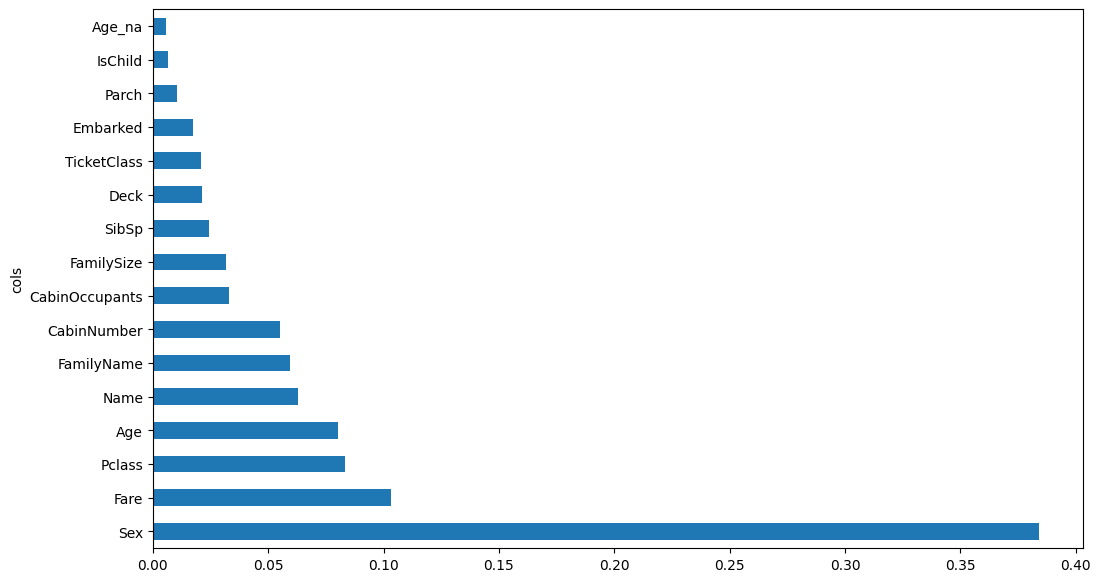

In [337]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [338]:
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

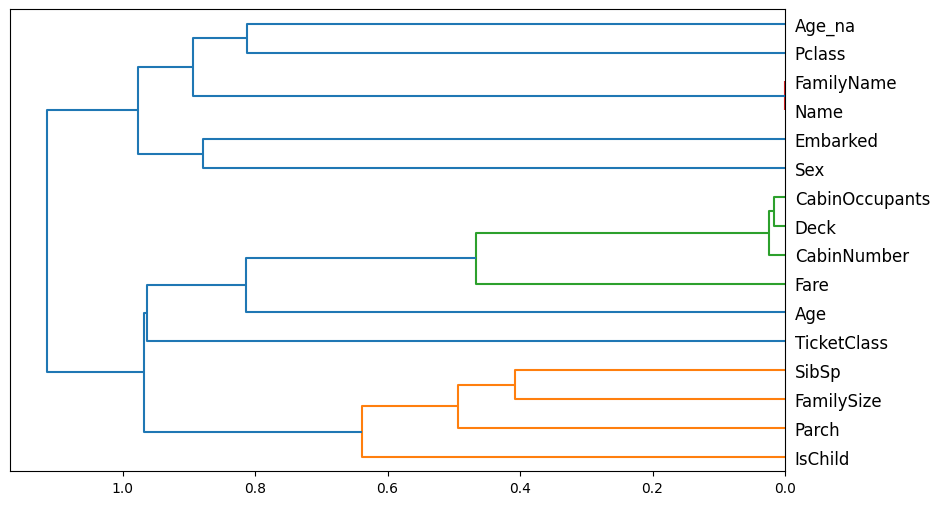

In [339]:
cluster_columns(to.train.xs)